In [38]:
import fastf1

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('ggplot')

## **Q1: “How much of a driver’s lap time affected from braking, throttle, and cornering efficiency across different circuits?”**

- Laptime Data

- Telemetry Data
    - Distance
    - Speed
    - Control
        - Brake
        - Throttle
        - Gear
        - DRS

- Track and Corner information
    - Corners
    - Apex
    - Track sector

- Weather Condition

- Tire and Car state


### Load

In [40]:
session = fastf1.get_session(2023, 'Monza', 'Q')
session.load()

fastest_lap = session.laps.pick_driver('LEC').pick_fastest()
slowest_lap = session.laps.pick_driver('LEC').sort_values('LapTime').iloc[-1]

core           INFO 	Loading data for Italian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '1', '16', '63', '11', '23', '81', '44', '4', '14', '22', '40', '27', '77', '2', '24', '10', '31', '20', '18']
c:\Users\khanh\anaconda3\envs\DDSC\Lib\site-packages\fastf1\core.py:3183: FutureWarning: pick_driver is depr

In [41]:
# Get telemetry
fast_lap_tel  = fastest_lap.get_telemetry().add_distance()
slow_lap_tel  = slowest_lap.get_telemetry().add_distance()

In [42]:
fast_lap_tel["Brake"] = fast_lap_tel["Brake"].replace({True: 100, False: 0})
fast_lap_tel["Pedal"] = fast_lap_tel["Throttle"] - fast_lap_tel["Brake"]

slow_lap_tel["Brake"] = slow_lap_tel["Brake"].replace({True: 100, False: 0})
slow_lap_tel["Pedal"] = slow_lap_tel["Throttle"] - slow_lap_tel["Brake"]

C:\Users\khanh\AppData\Local\Temp\ipykernel_33892\3004598896.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fast_lap_tel["Brake"] = fast_lap_tel["Brake"].replace({True: 100, False: 0})
C:\Users\khanh\AppData\Local\Temp\ipykernel_33892\3004598896.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  slow_lap_tel["Brake"] = slow_lap_tel["Brake"].replace({True: 100, False: 0})


### Brake Skill

In [43]:
# Find brake zones
def find_brake_zones(telemetry):
    '''
    Identify brake zones from telemetry data.
    Returns a DataFrame with brake zone start/end points.
    '''
    brake_zones = []
    braking = False
    start_idx = None
    
    for idx, row in telemetry.iterrows():
        if row['Brake'] > 0 and not braking:
            # Start of brake zone
            braking = True
            start_idx = idx
        elif row['Brake'] == 0 and braking:
            # End of brake zone
            braking = False
            if start_idx is not None:
                brake_zones.append({
                    'start_distance': telemetry.loc[start_idx, 'Distance'],
                    'end_distance': telemetry.loc[idx, 'Distance'],
                    'duration': (telemetry.loc[idx, 'Time'] - telemetry.loc[start_idx, 'Time']).total_seconds(),
                    'start_speed': telemetry.loc[start_idx, 'Speed'],
                    'end_speed': telemetry.loc[idx, 'Speed']
                })
    
    return pd.DataFrame(brake_zones)

# Find brake zones for both laps
fast_brake_zones = find_brake_zones(fast_lap_tel)
slow_brake_zones = find_brake_zones(slow_lap_tel)

print(f"Fast lap brake zones: {len(fast_brake_zones)}")
print(fast_brake_zones)

Fast lap brake zones: 7
   start_distance  end_distance  duration  start_speed  end_speed
0      794.129362    915.215932      2.68        325.0       83.0
1      935.259065    950.161365      0.68         87.0       75.0
2     2039.553669   2126.320549      2.20        246.0      109.0
3     2445.872304   2497.786592      0.84        247.0      209.0
4     2788.510980   2840.601667      0.92        239.0      187.0
5     3848.811943   3918.608709      1.16        275.0      195.0
6     5027.378179   5126.887718      1.40        322.0      225.0


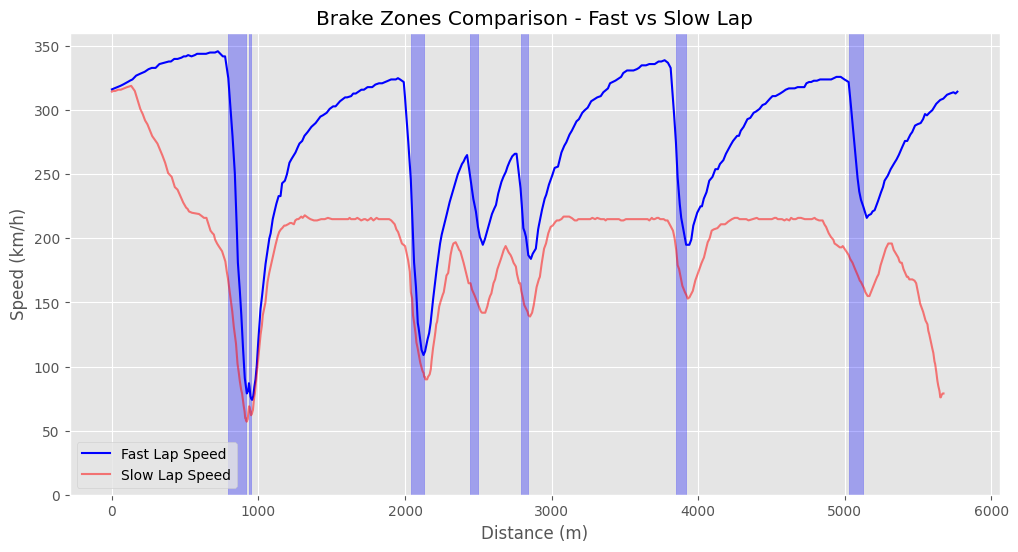

In [44]:
# Plot fast lap brake zones compare to slow lap
plt.figure(figsize=(12, 6))
plt.plot(fast_lap_tel['Distance'], fast_lap_tel['Speed'], label='Fast Lap Speed', color='blue')
plt.plot(slow_lap_tel['Distance'], slow_lap_tel['Speed'], label='Slow Lap Speed', color='red', alpha=0.5)
for _, zone in fast_brake_zones.iterrows():
    plt.axvspan(zone['start_distance'], zone['end_distance'], color='blue', alpha=0.3)
plt.title('Brake Zones Comparison - Fast vs Slow Lap')
plt.xlabel('Distance (m)')
plt.ylabel('Speed (km/h)')
plt.ylim(0, None)
plt.legend()
plt.show()

### Throttle
- Throttle out of a corner
- Speed build up 
- Gear changes

In [45]:
# Find corner entry and exit points based on speed changes
circuit_info = session.get_circuit_info()
pos = fastest_lap.get_pos_data()


In [46]:
# Speed exiting the corner
def find_corner_exit_speeds(telemetry, circuit_info):
    corner_exits = []

    def find_exit(telemetry, apex_idx, threshold=50):
        exit_data = telemetry.loc[apex_idx:]

        throttle_on = exit_data[exit_data['Throttle'] > threshold]

        return throttle_on.index[0] if not throttle_on.empty else exit_data.index[-1]

    for _, corner in circuit_info.corners.iterrows():
        corner_x, corner_y = corner['X'], corner['Y']

        # Distance from each telemetry point to the corner
        distances = np.sqrt((telemetry['X'] - corner_x) ** 2 + (telemetry['Y'] - corner_y) ** 2)

        # Apex
        apex_idx = distances.idxmin()

        # Exit point: first point after apex where distance starts increasing
        exit_idx = find_exit(telemetry, apex_idx, threshold=50)

        corner_exits.append({
            'corner': f"{corner['Number']}{corner['Letter']}",
            'exit_speed': telemetry.loc[exit_idx, 'Speed'],
            'exit_distance': telemetry.loc[exit_idx, 'Distance'],
            'apex_speed': telemetry.loc[apex_idx, 'Speed']
        })

    return pd.DataFrame(corner_exits)

fast_corner_exits = find_corner_exit_speeds(fast_lap_tel, circuit_info)
slow_corner_exits = find_corner_exit_speeds(slow_lap_tel, circuit_info)
print("Fast lap corner exit speeds:")
print(fast_corner_exits)

print("Slow lap corner exit speeds:")
print(slow_corner_exits)

    


Fast lap corner exit speeds:
   corner  exit_speed  exit_distance  apex_speed
0       1   84.000000     971.760106  114.000000
1       2   84.000000     971.760106   75.000000
2       3  298.000000    1465.636752  298.000000
3       4  110.633331    2132.330586  113.000000
4       5  126.000000    2164.633724  126.000000
5       6  198.600000    2542.842277  197.325005
6       7  184.700002    2854.771631  186.866667
7       8  195.000000    3929.225375  195.000000
8       9  221.888889    4002.425353  221.888889
9      10  253.057137    4114.883213  253.057137
10     11  221.000000    5190.100479  221.000000
Slow lap corner exit speeds:
   corner  exit_speed  exit_distance  apex_speed
0       1   83.921870     979.547056   75.000000
1       2   83.921870     979.547056   62.000000
2       3  215.650000    1466.318589  215.650000
3       4   98.000000    2176.241288   97.211620
4       5   98.000000    2176.241288   93.984924
5       6  142.000000    2547.406217  142.000000
6       7  

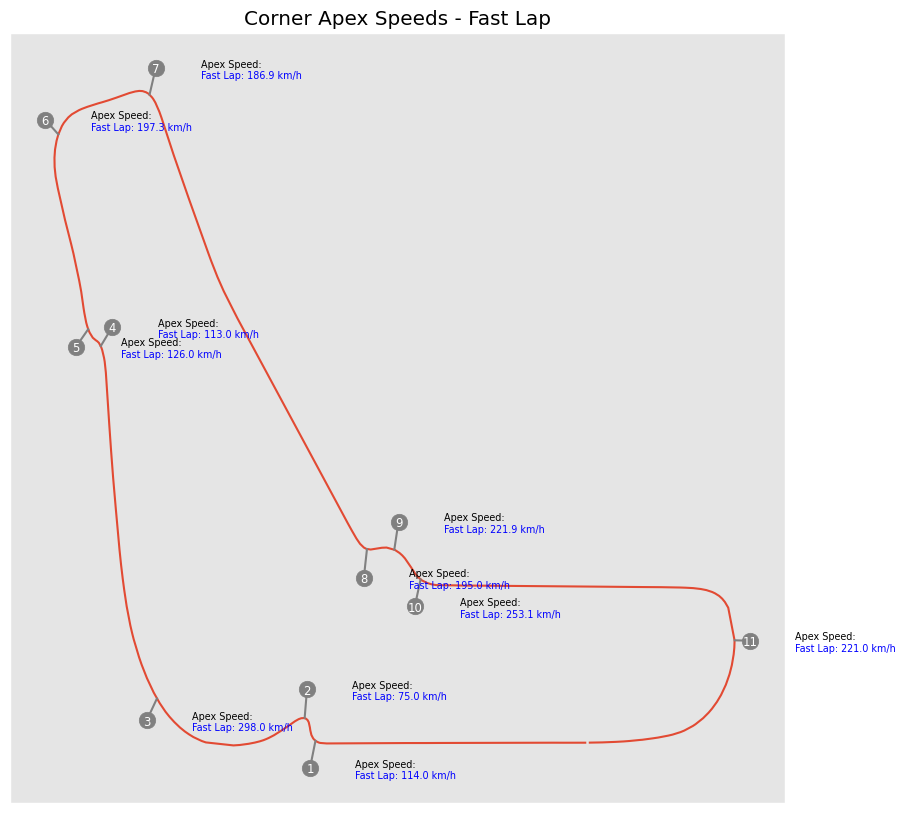

In [47]:
fig, ax = plt.subplots(figsize=(10, 10))

def rotate(xy, *, angle):
    rot_mat = np.array([[np.cos(angle), np.sin(angle)],
                        [-np.sin(angle), np.cos(angle)]])
    return np.matmul(xy, rot_mat)
# Get an array of shape [n, 2] where n is the number of points and the second
# axis is x and y.
track = pos.loc[:, ('X', 'Y')].to_numpy()

# Convert the rotation angle from degrees to radian.
track_angle = circuit_info.rotation / 180 * np.pi

# Rotate and plot the track map.
rotated_track = rotate(track, angle=track_angle)
plt.plot(rotated_track[:, 0], rotated_track[:, 1])

offset = [500, 0]  # Offset for text labels

# Iterate over all corners.
for _, corner in circuit_info.corners.iterrows():
    # Create a string from corner number and letter
    txt = f"{corner['Number']}{corner['Letter']}"

    # Convert the angle from degrees to radian.
    offset_angle = corner['Angle'] / 180 * np.pi

    # Rotate the offset vector so that it points sideways from the track.
    offset_x, offset_y = rotate(offset, angle=offset_angle)

    # Add the offset to the position of the corner
    text_x = corner['X'] + offset_x
    text_y = corner['Y'] + offset_y

    # Rotate the text position equivalently to the rest of the track map
    text_x, text_y = rotate([text_x, text_y], angle=track_angle)

    # Rotate the center of the corner equivalently to the rest of the track map
    track_x, track_y = rotate([corner['X'], corner['Y']], angle=track_angle)

    # Draw a circle next to the track.
    ax.scatter(text_x, text_y, color='grey', s=140)

    # Write apex speed next to the circle
    apex_speed = fast_corner_exits.loc[fast_corner_exits['corner'] == txt, 'apex_speed'].values
    slow_lap_apex_speed = slow_corner_exits.loc[slow_corner_exits['corner'] == txt, 'apex_speed'].values
    if apex_speed.size > 0:
        ax.text(text_x + 1500, text_y + 150, "Apex Speed:", va='top', ha='left', size='x-small')
        ax.text(text_x + 1500, text_y - 50, f"Fast Lap: {apex_speed[0]:.1f} km/h", va='top', ha='left', size='x-small', color='blue')
    # Draw a line from the track to this circle.
    ax.plot([track_x, text_x], [track_y, text_y], color='grey')
    plt.xticks([])
    plt.yticks([])
    
    ax.set_title('Corner Apex Speeds - Fast Lap')
    # Finally, print the corner number inside the circle.
    ax.text(text_x, text_y, txt,
             va='center_baseline', ha='center', size='small', color='white')

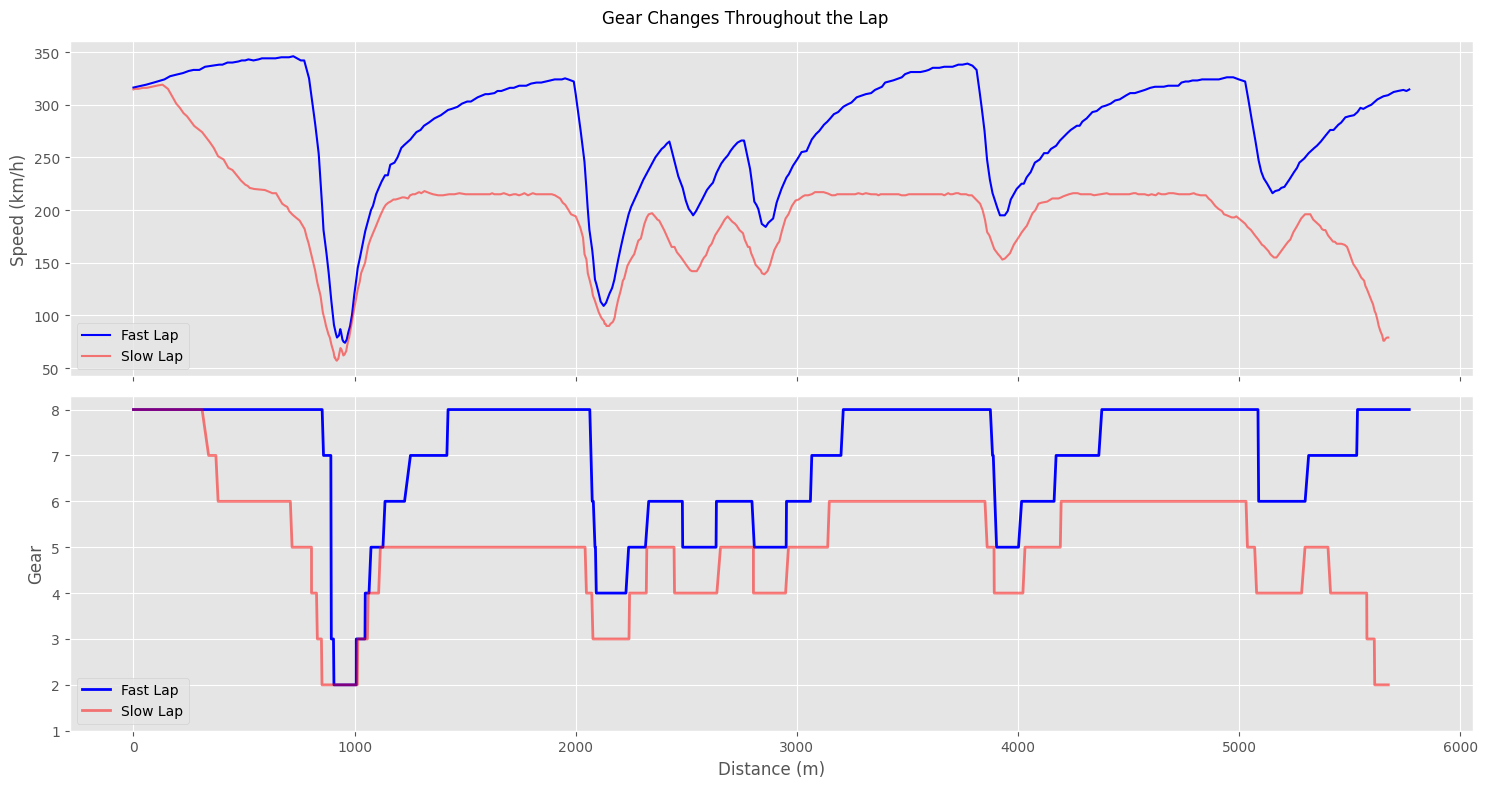

In [48]:
# Gear changes visualization 
# Plot gear changes over distance
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# Speed plot
ax1.plot(fast_lap_tel['Distance'], fast_lap_tel['Speed'], label='Fast Lap', color='blue')
ax1.plot(slow_lap_tel['Distance'], slow_lap_tel['Speed'], label='Slow Lap', color='red', alpha=0.5)
ax1.set_ylabel('Speed (km/h)')
ax1.legend()
ax1.grid(True)

# Gear plot
ax2.plot(fast_lap_tel['Distance'], fast_lap_tel['nGear'], label='Fast Lap', color='blue', linewidth=2)
ax2.plot(slow_lap_tel['Distance'], slow_lap_tel['nGear'], label='Slow Lap', color='red', alpha=0.5, linewidth=2)
ax2.set_xlabel('Distance (m)')
ax2.set_ylabel('Gear')
ax2.set_yticks(range(1, 9))
ax2.legend()
ax2.grid(True)

plt.suptitle('Gear Changes Throughout the Lap')
plt.tight_layout()
plt.show()

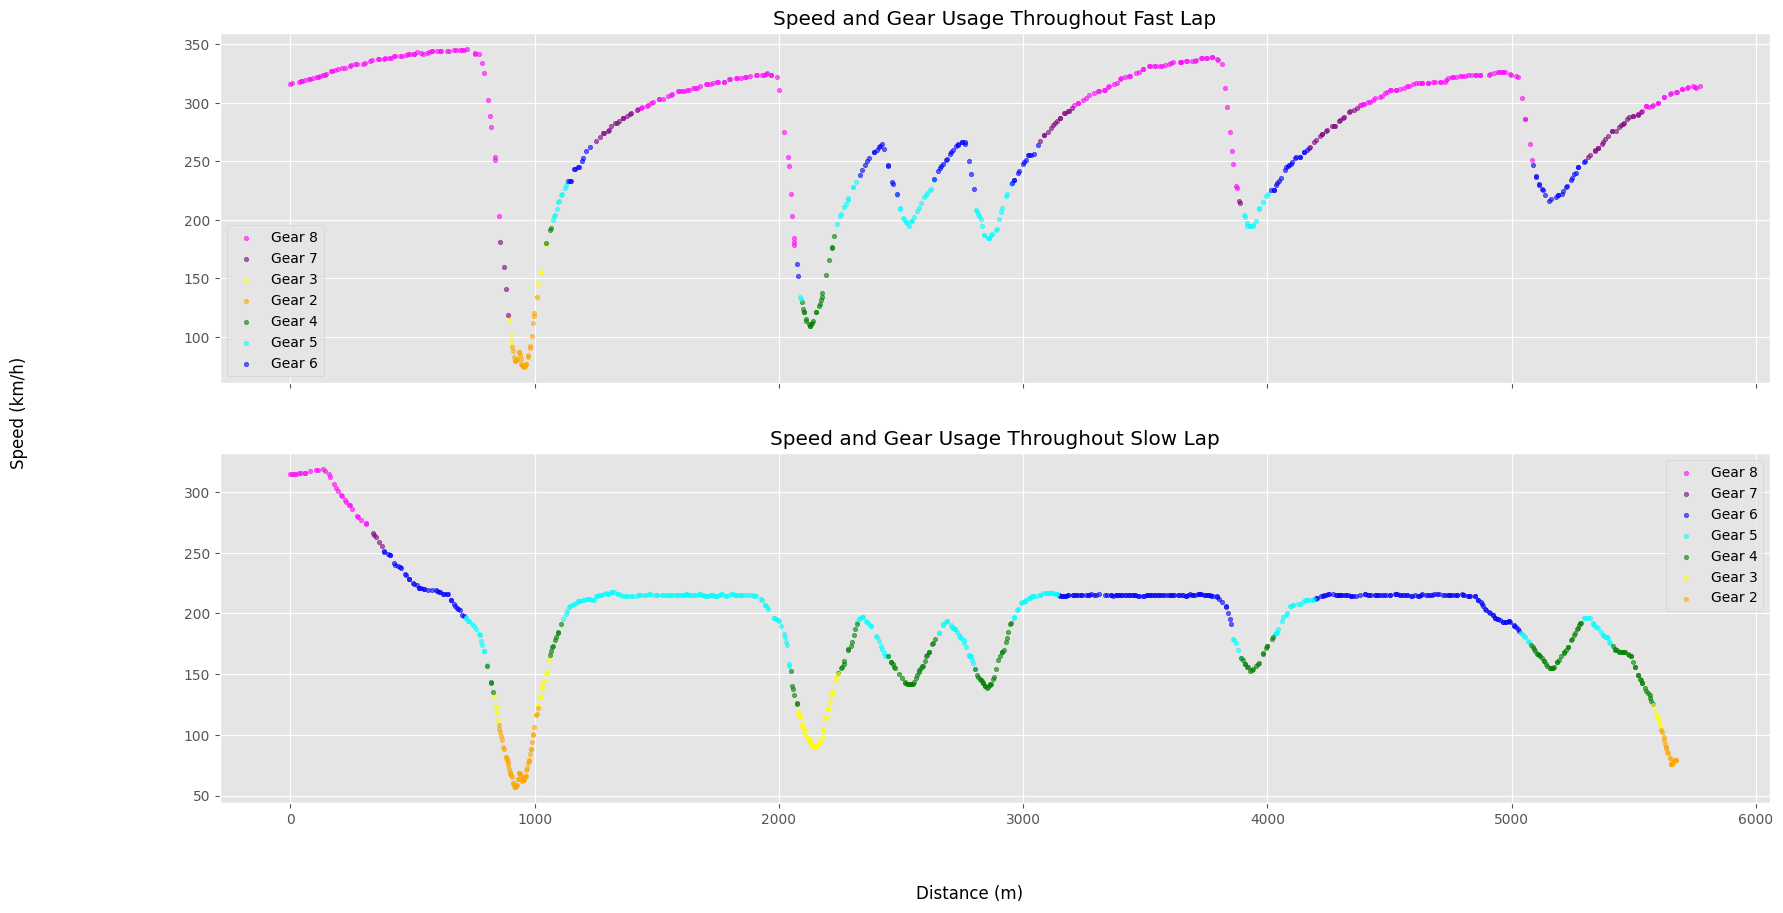

In [49]:
# Plot gear changes with color coding
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

# Color each gear differently
colors = {1: 'red', 2: 'orange', 3: 'yellow', 4: 'green', 
          5: 'cyan', 6: 'blue', 7: 'purple', 8: 'magenta'}

for gear in fast_lap_tel['nGear'].unique():
    gear_data = fast_lap_tel[fast_lap_tel['nGear'] == gear]
    ax1.scatter(gear_data['Distance'], gear_data['Speed'], 
               c=colors.get(gear, 'black'), label=f'Gear {gear}', s=10, alpha=0.6)
    
for gear in slow_lap_tel['nGear'].unique():
    gear_data = slow_lap_tel[slow_lap_tel['nGear'] == gear]
    ax2.scatter(gear_data['Distance'], gear_data['Speed'], 
               c=colors.get(gear, 'black'), label=f'Gear {gear}', s=10, alpha=0.6)
fig.supylabel('Speed (km/h)')
ax1.set_title('Speed and Gear Usage Throughout Fast Lap')
fig.supxlabel('Distance (m)')
ax2.set_title('Speed and Gear Usage Throughout Slow Lap')
ax1.legend()
ax2.legend()
plt.show()

## **Q2: "What is the tyre wear–pace decay curve for each compound under track temperature conditions?"**

- Lap delta modeling
- Tyre compound and temperature and interaction
- Anomalies (safety car)

In [50]:
laps = session.laps
laps



,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 00:20:31.721000,SAI,55,NaT,1.0,1.0,0 days 00:18:48.066000,NaT,NaT,0 days 00:00:33.832000,...,True,Ferrari,0 days 00:18:48.066000,2023-09-02 14:03:48.177,1,NaN,False,,False,False
1,0 days 00:21:54.042000,SAI,55,0 days 00:01:22.321000,2.0,1.0,NaT,NaT,0 days 00:00:27.450000,0 days 00:00:27.716000,...,True,Ferrari,0 days 00:20:31.721000,2023-09-02 14:05:31.832,1,NaN,False,,False,True
2,0 days 00:23:58.446000,SAI,55,0 days 00:02:04.404000,3.0,1.0,NaT,0 days 00:23:52.297000,0 days 00:00:46.347000,0 days 00:00:38.123000,...,True,Ferrari,0 days 00:21:54.042000,2023-09-02 14:06:54.153,1,NaN,False,,False,False
3,0 days 00:26:20.784000,SAI,55,0 days 00:02:22.338000,4.0,2.0,0 days 00:24:23.406000,NaT,0 days 00:01:10.499000,0 days 00:00:37.488000,...,False,Ferrari,0 days 00:23:58.446000,2023-09-02 14:08:58.557,1,NaN,False,,False,False
4,0 days 00:27:42.749000,SAI,55,0 days 00:01:21.965000,5.0,2.0,NaT,NaT,0 days 00:00:27.262000,0 days 00:00:27.655000,...,False,Ferrari,0 days 00:26:20.784000,2023-09-02 14:11:20.895,1,NaN,False,,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,0 days 00:28:55.941000,STR,18,NaT,5.0,2.0,0 days 00:27:25.310000,NaT,NaT,0 days 00:00:30.149000,...,True,Aston Martin,0 days 00:25:17.470000,2023-09-02 14:10:17.581,1,NaN,False,,False,False
323,0 days 00:30:18.801000,STR,18,0 days 00:01:22.860000,6.0,2.0,NaT,NaT,0 days 00:00:27.267000,0 days 00:00:28.076000,...,True,Aston Martin,0 days 00:28:55.941000,2023-09-02 14:13:56.052,1,NaN,False,,False,True
324,0 days 00:32:03.714000,STR,18,0 days 00:01:44.913000,7.0,2.0,NaT,NaT,0 days 00:00:37.274000,0 days 00:00:36.331000,...,True,Aston Martin,0 days 00:30:18.801000,2023-09-02 14:15:18.912,1,NaN,False,,False,True
325,0 days 00:33:26.597000,STR,18,0 days 00:01:22.883000,8.0,2.0,NaT,NaT,0 days 00:00:27.281000,0 days 00:00:28.239000,...,True,Aston Martin,0 days 00:32:03.714000,2023-09-02 14:17:03.825,1,NaN,False,,False,True


In [63]:
# Tyre age
laps.loc[:, 'LapTimeSeconds'] = laps['LapTime'].dt.total_seconds()

# Filter out outliers
# Safety car laps and invalid laps
clean_laps = laps[(laps['LapTimeSeconds'].notna()) | (laps['TrackStatus'].isin([1]))]


# How many safety laps
count_safety_laps = len(laps[laps['TrackStatus'] == 4])


print(f"Total laps: {len(laps)}, Clean laps: {len(clean_laps)}")
print(clean_laps[['LapNumber', 'LapTime', 'Compound', 'TyreLife', 'FreshTyre']])
print(f"Safety laps: {count_safety_laps}")

Total laps: 327, Clean laps: 228
     LapNumber                LapTime Compound  TyreLife  FreshTyre
1          2.0 0 days 00:01:22.321000     HARD       2.0       True
2          3.0 0 days 00:02:04.404000     HARD       3.0       True
3          4.0 0 days 00:02:22.338000     HARD       4.0      False
4          5.0 0 days 00:01:21.965000     HARD       5.0      False
5          6.0 0 days 00:01:59.905000     HARD       6.0      False
..         ...                    ...      ...       ...        ...
321        4.0 0 days 00:01:42.881000     HARD       4.0       True
323        6.0 0 days 00:01:22.860000     HARD       2.0       True
324        7.0 0 days 00:01:44.913000     HARD       3.0       True
325        8.0 0 days 00:01:22.883000     HARD       4.0       True
326        9.0 0 days 00:01:45.627000     HARD       5.0       True

[228 rows x 5 columns]
Safety laps: 0


In [ ]:
### THIS PART ###
### This part is wrong because for TyreLife and FreshTyre does not match up
### Might be better to understand the 2 better
### ----------###

results = []
for driver in clean_laps['Driver'].unique():
    driver_laps = clean_laps[clean_laps['Driver'] == driver].copy()
    for compound in driver_laps['Compound'].unique():
        compound_laps = driver_laps[driver_laps['Compound'] == compound].copy()

        # Calculate pace decay (delta to first lap on that compound)
        first_lap_time = compound_laps.iloc[0]['LapTimeSeconds']
        compound_laps.loc[:, 'PaceDecay'] = compound_laps['LapTimeSeconds'] - first_lap_time

        # Linear regression: PaceDecay ~ TyreLife
        from scipy.stats import linregress
        X = compound_laps['TyreLife'].values
        y = compound_laps['LapTimeSeconds'].values
        slope, intercept, r_value, p_value, std_err = linregress(X, y)

        results.append({
            'Driver': driver,
            'Compound': compound,
            'Slope': slope,
            'Intercept': intercept,
            'R_squared': r_value**2,
            'AvgLapTime': compound_laps['LapTimeSeconds'].mean(),
        })
results_df = pd.DataFrame(results)

# Count how many laps per driver and compound
lap_counts = clean_laps.groupby(['Driver', 'Compound']).size().reset_index(name='LapCount')
results_df = results_df.merge(lap_counts, on=['Driver', 'Compound'])

print(results_df)

   Driver Compound      Slope   Intercept  R_squared  AvgLapTime  LapCount
0     SAI     HARD   0.309536  109.446429   0.000791  111.148875         8
1     SAI   MEDIUM  20.266500   47.115500   0.755440   94.404000         3
2     SAI     SOFT  33.796000   12.821000   0.960464   97.311000         4
3     VER     HARD   1.346452  100.479762   0.018869  107.885250         8
4     VER   MEDIUM  26.858500   27.269000   0.992641   94.415250         4
5     VER     SOFT  12.906000   54.657000   0.999528   84.771000         3
6     LEC     HARD   1.485155   96.273524   0.033235  104.441875         8
7     LEC   MEDIUM  25.132500   30.811000   0.994884   93.642250         4
8     LEC     SOFT  22.365500   35.731500   0.999938   87.917667         3
9     RUS     HARD   5.197521   85.084854   0.102394  103.647429         7
10    RUS   MEDIUM  27.892000   25.647000   0.989275   95.377000         4
11    RUS     SOFT  19.012000   42.693000   0.999982   87.054333         3
12    PER     HARD   0.87

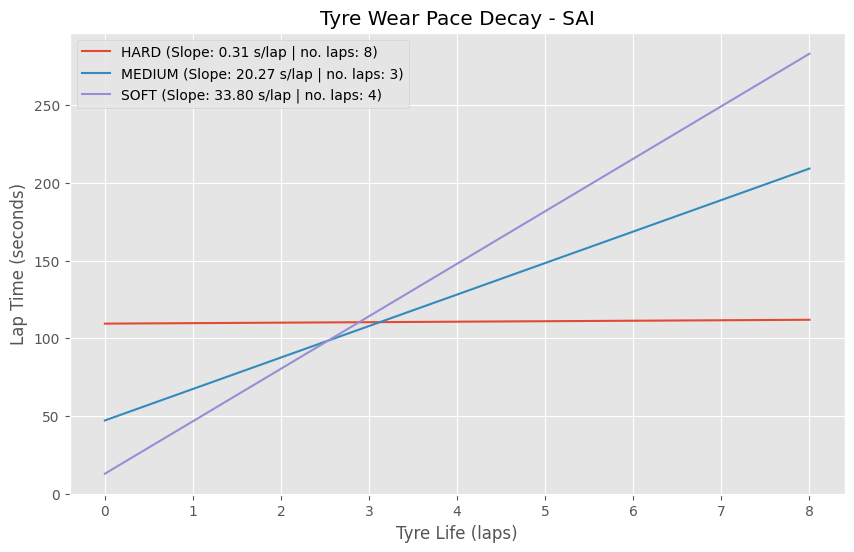

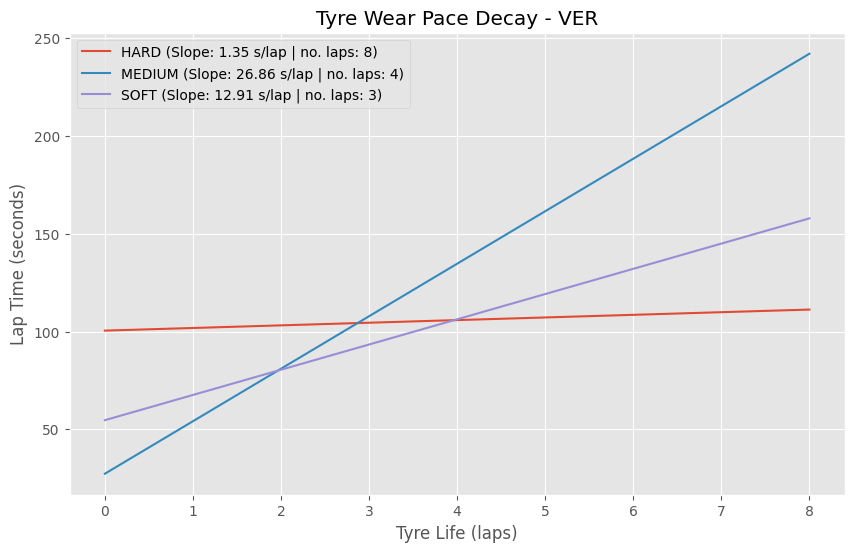

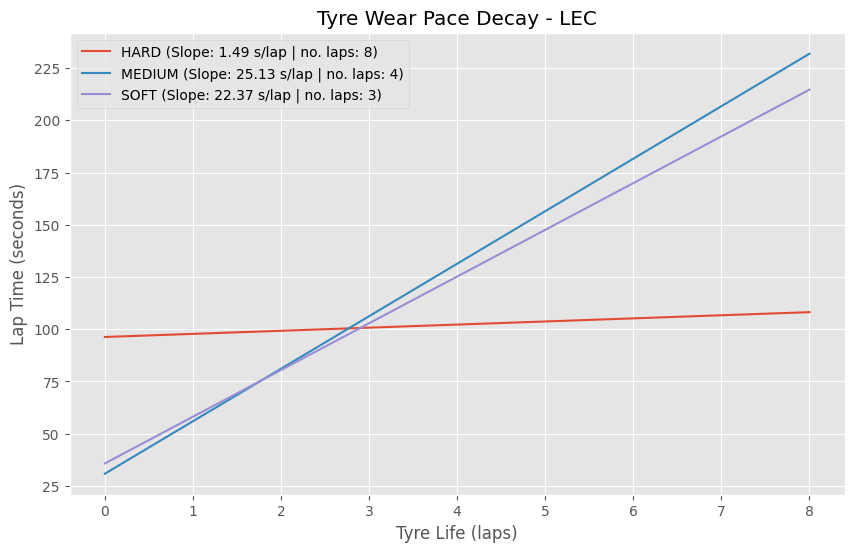

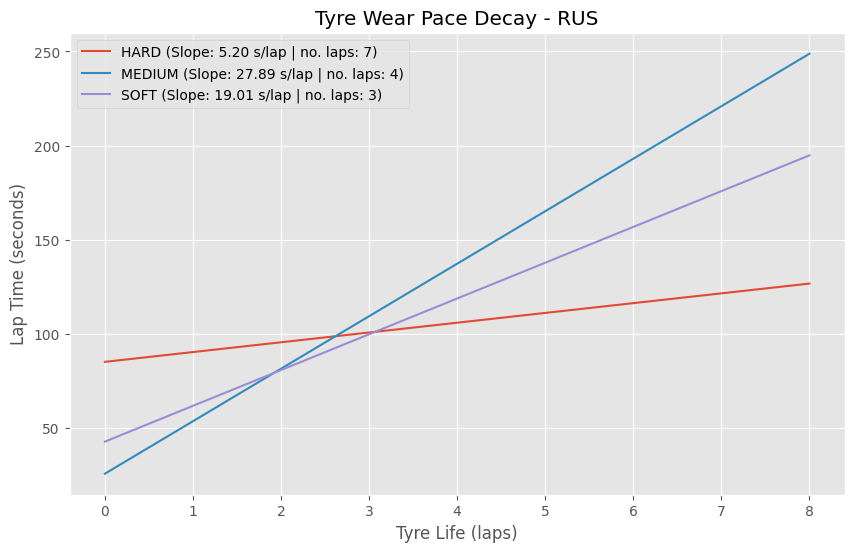

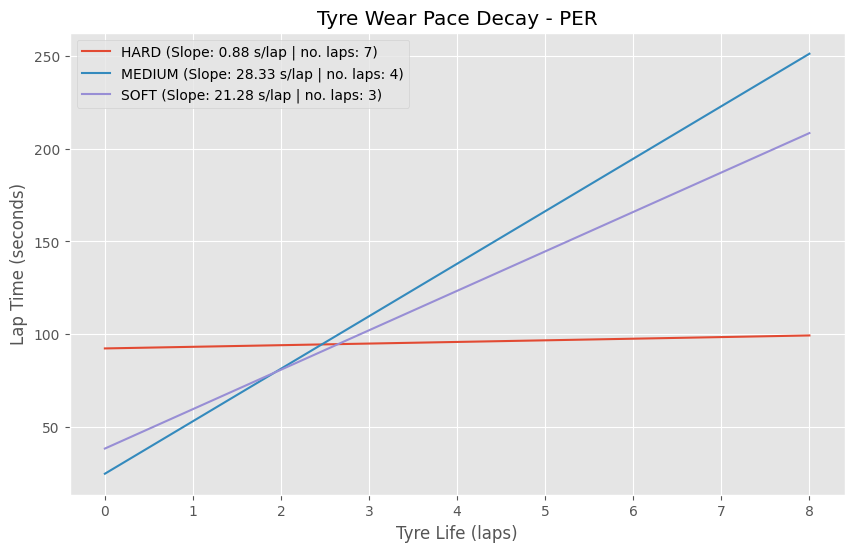

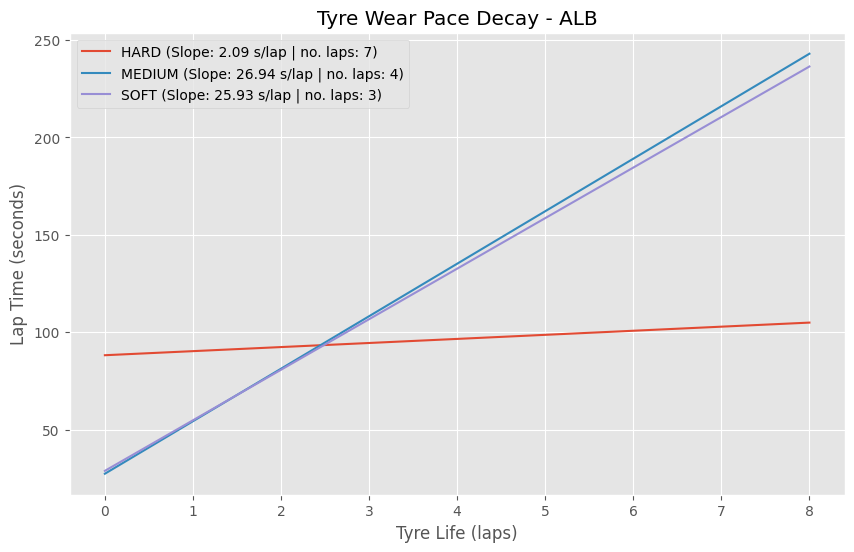

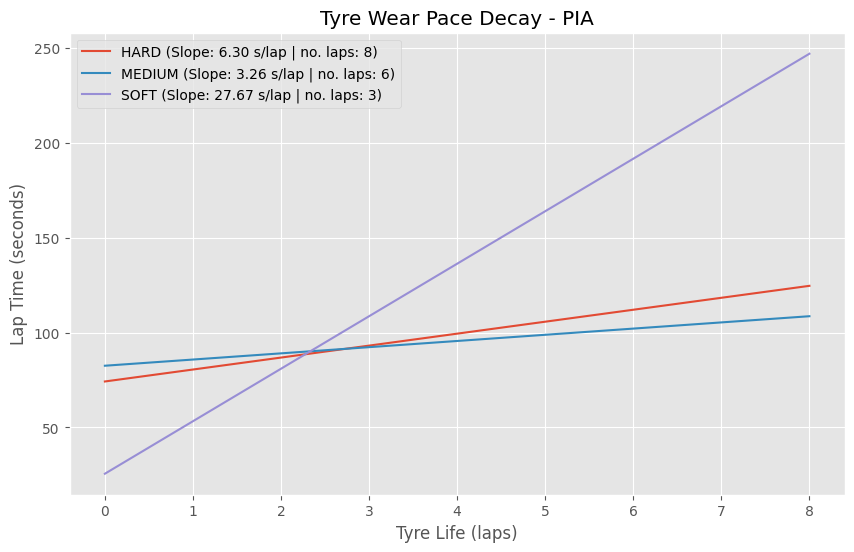

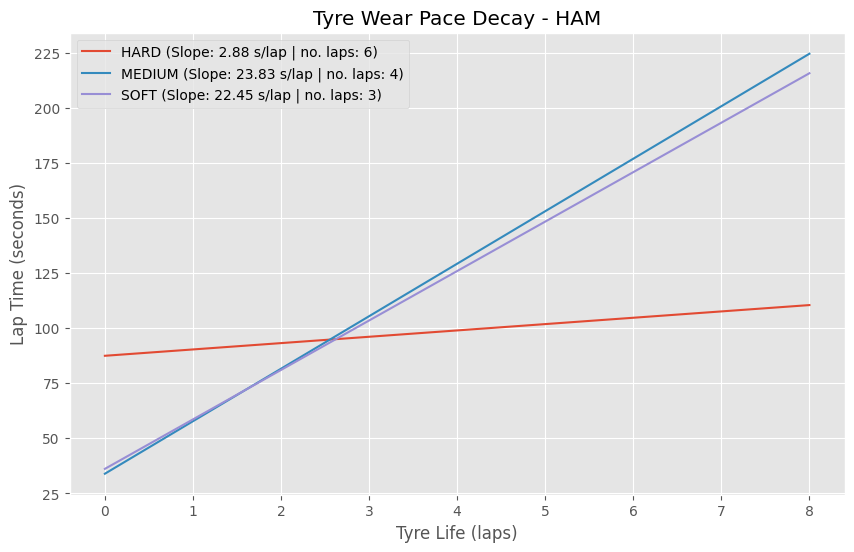

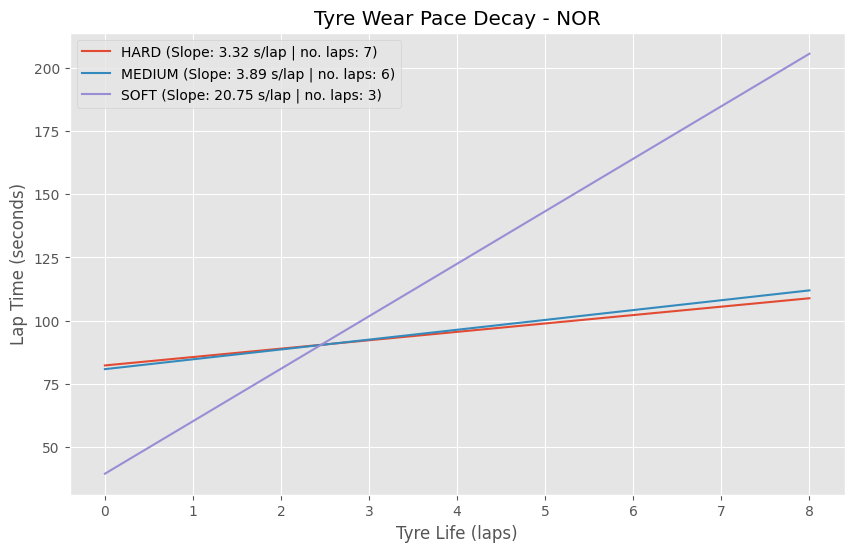

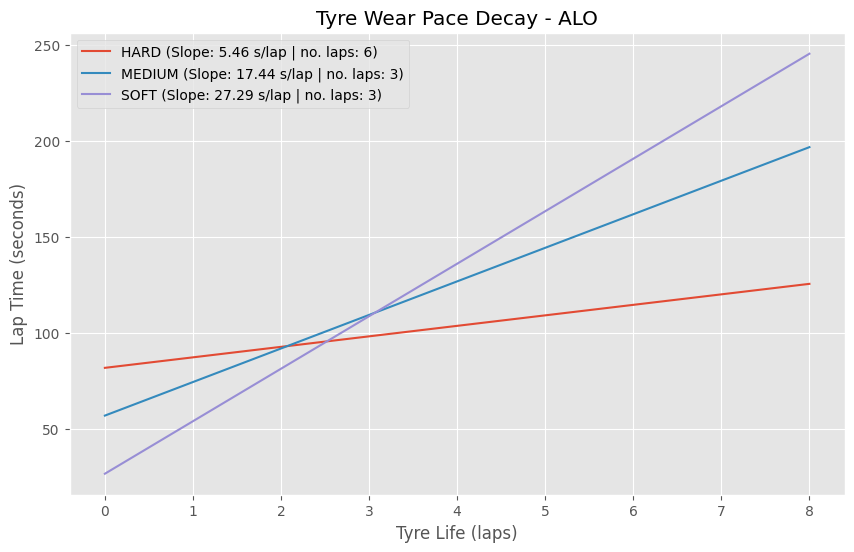

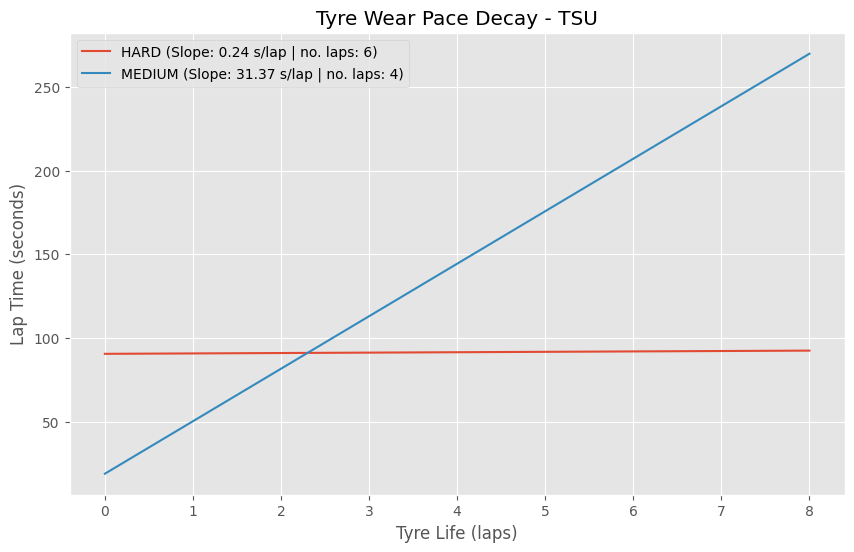

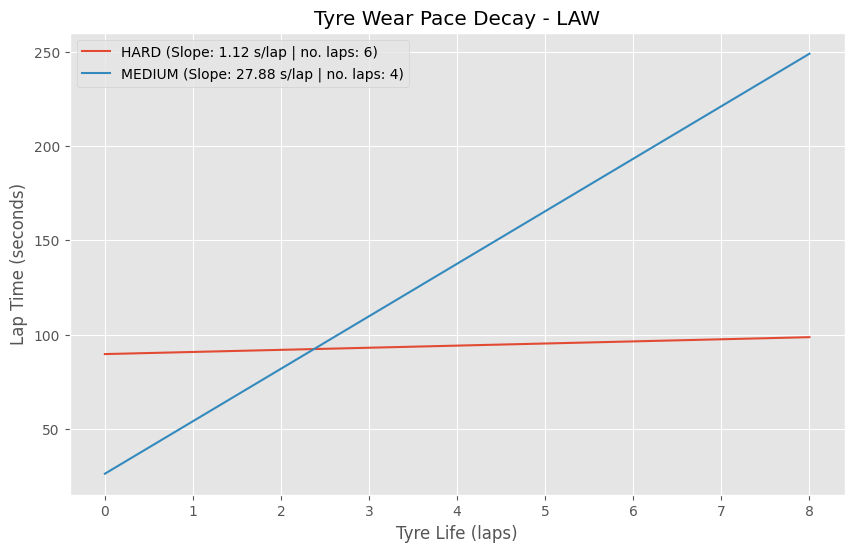

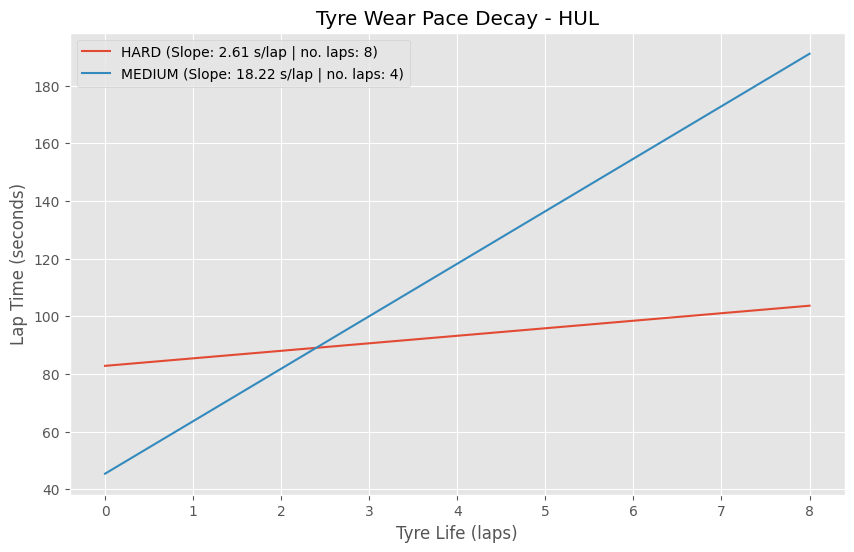

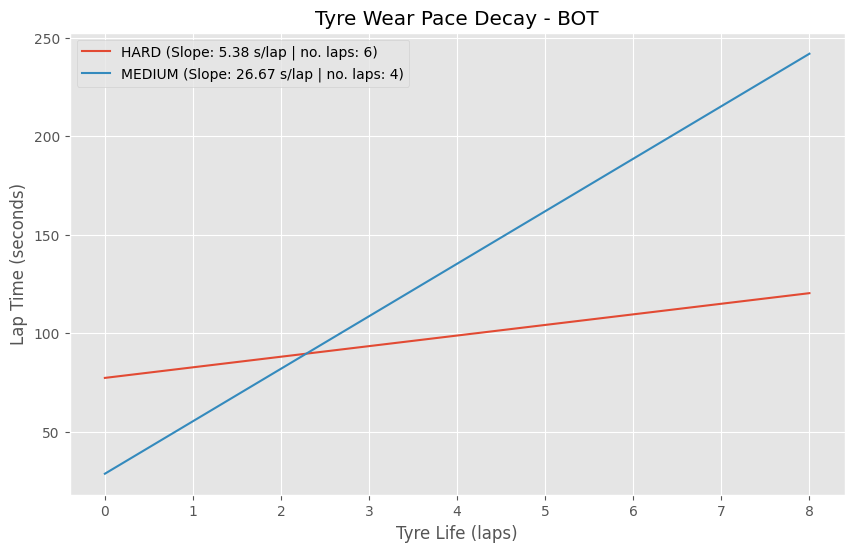

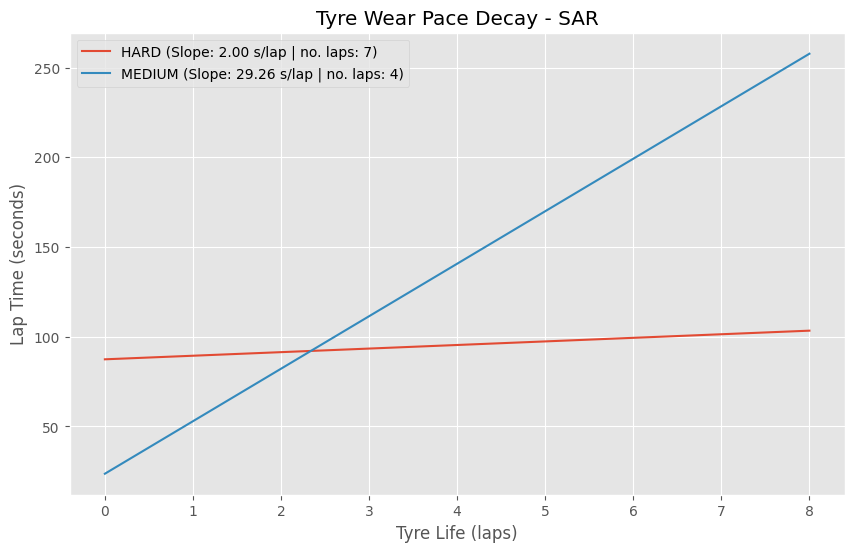

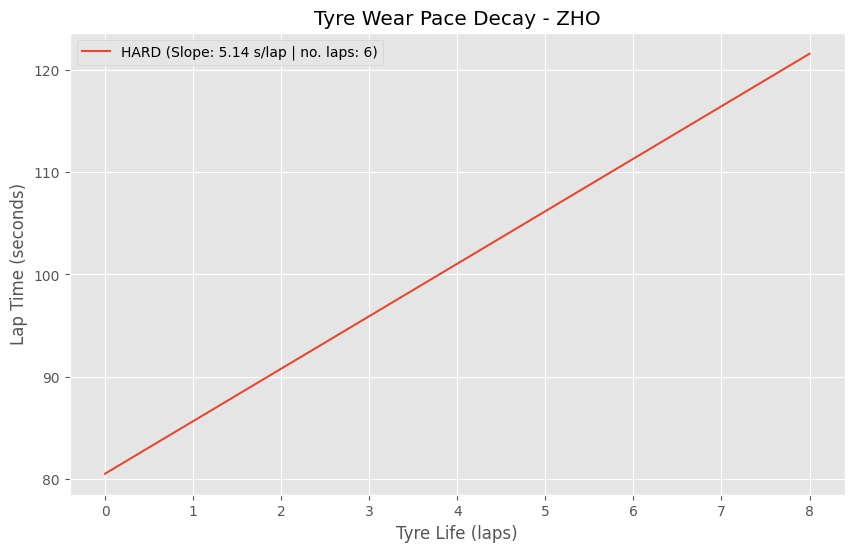

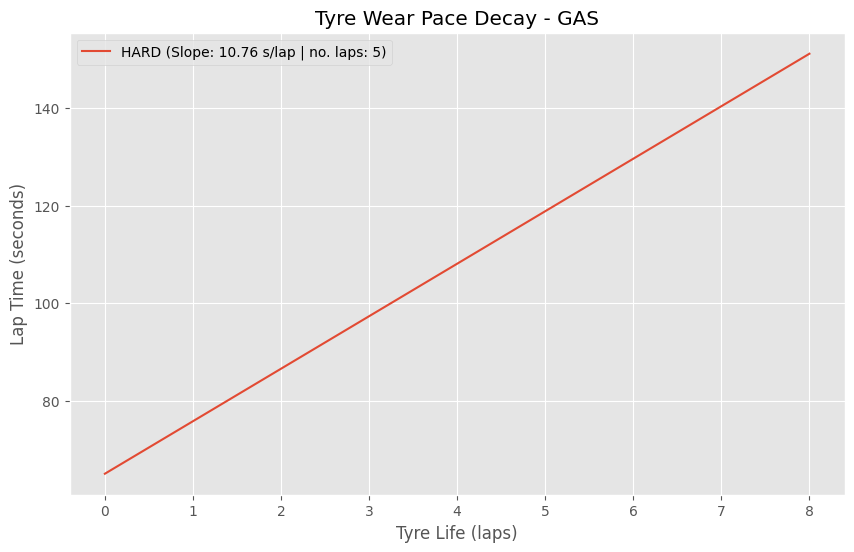

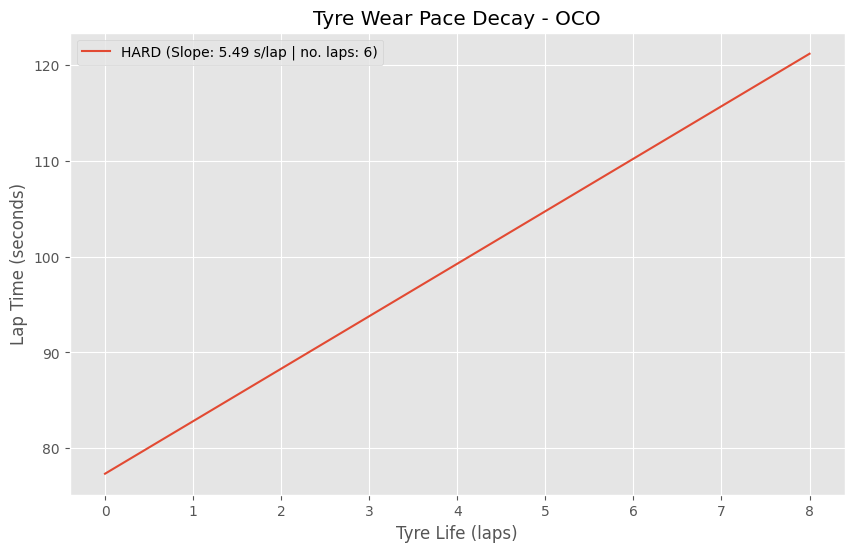

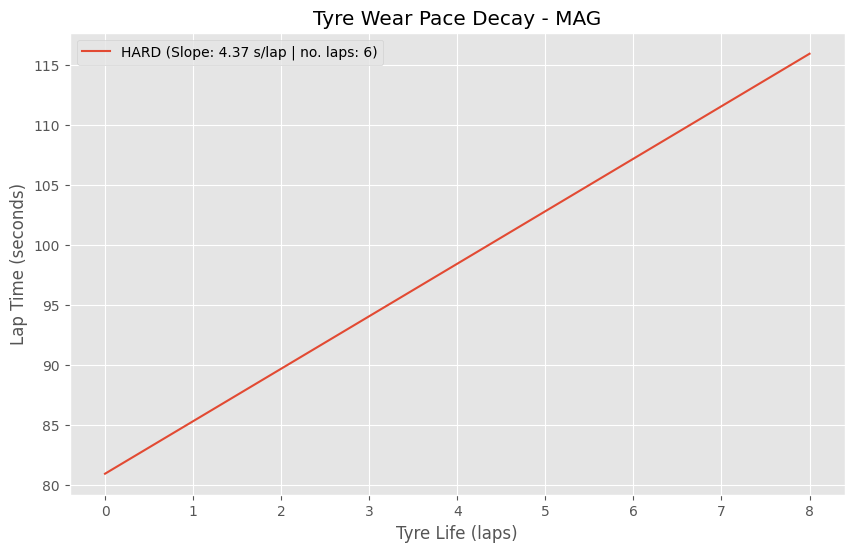

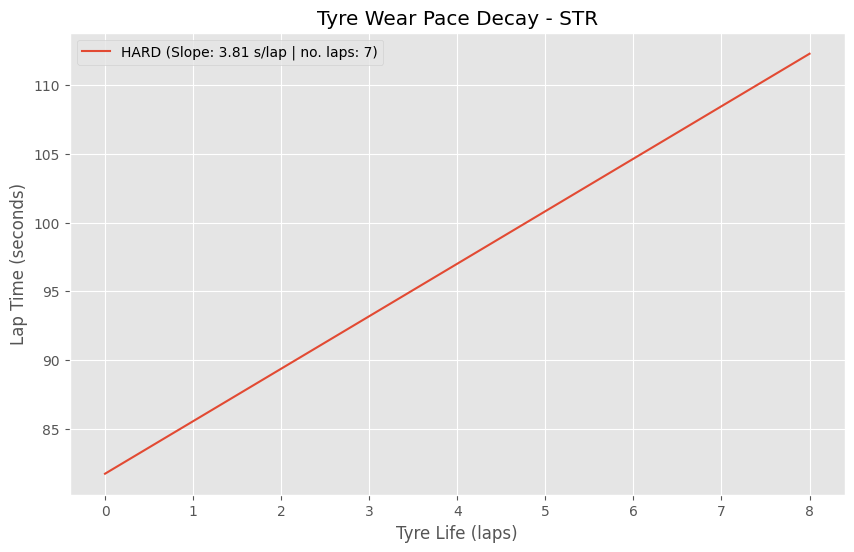

In [53]:
for driver in results_df['Driver'].unique():
    driver_data = results_df[results_df['Driver'] == driver]
    plt.figure(figsize=(10, 6))
    for _, row in driver_data.iterrows():
        x = np.array([0, 8]) # Tyre life from 0 to 8 laps
        y = row['Intercept'] + row['Slope'] * x
        plt.plot(x, y, label=f"{row['Compound']} (Slope: {row['Slope']:.2f} s/lap | no. laps: {row['LapCount']})")
    plt.title(f'Tyre Wear Pace Decay - {driver}')
    plt.xlabel('Tyre Life (laps)')
    plt.ylabel('Lap Time (seconds)')
    plt.legend()
    plt.grid(True)
    plt.show()